In [29]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import shap

%run ../../helper/preprocess.py
%run ../../helper/aggregate.py
%run ../../helper/utils.py
%run shap_analysis.py

shap.initjs()
matplotlib.rcParams['pdf.fonttype'] = 42
sns.set(font_scale=1.4)
sns.set_style("white")

In [2]:
metrics_file = '../../metrics/ddim_sd15_metrics.csv'
config_file = '../../../exp_configs/config_mapping.csv'

keywords_to_exclude = ['1027', '1007', '1017', ]
# keywords_to_exclude = []

metrics_processed = load_and_preprocess_metrics(
    metrics_file,
    config_file,
    rank=True,
    metrics_to_include=None,
    keywords_to_exclude=keywords_to_exclude)

In [3]:
keywords_to_exclude = ['1003', '1013', '1023']
metrics_processed = metrics_processed[metrics_processed['Config'].apply(
    lambda x: not any(keyword in x for keyword in keywords_to_exclude))]
print(metrics_processed.shape)

(8073, 82)


In [4]:
8424/39/9

24.0

## Per category: People

In [4]:
category = 'style'

metrics_aggregated = aggregate_metrics(
    metrics_processed[metrics_processed['Category'] == category],
    level='All',
    group_seeds=False)
print(metrics_aggregated.shape)

(207, 149)


In [11]:
metric_types = ['Style Loss', 'Text Similarity', 'Vendi']
encoders = ['Vgg19', 'CLIP', 'DINOv2', 'Vgg19']
modes = ['padding']
prompt_types = ['in', 'trigger', 'out']

metrics_to_include = get_metric_list(metric_types, encoders, modes,
                                     prompt_types, style_with_base_model=False)

In [12]:
del metrics_to_include[3]
del metrics_to_include[3]
del metrics_to_include[4]
del metrics_to_include[5]
metrics_to_include.append(('Style Loss', 'Vgg19', 'base model'))

In [13]:
metrics_to_include

[('Style Loss', 'Vgg19', 'in'),
 ('Style Loss', 'Vgg19', 'trigger'),
 ('Style Loss', 'Vgg19', 'out'),
 ('Text Similarity', 'CLIP', 'out'),
 ('Vendi', 'DINOv2', 'trigger'),
 ('Style Loss', 'Vgg19', 'base model')]

In [25]:
metrics_to_include = [('Image Similarity', 'DINOv2-padding', 'out'),
                      ('Image Similarity', 'DINOv2-padding', 'trigger'),
                      ('Image Similarity', 'DINOv2-padding', 'in'),
                      ('Text Similarity', 'CLIP', 'out'),
                      ('Style Loss', 'Vgg19', 'out'),
                      ('Style Loss', 'Vgg19', 'trigger'),
                      ('Style Loss', 'Vgg19', 'in'),
                      ('Vendi', 'DINOv2', 'trigger'),]
                      #('Style Loss', 'Vgg19', 'base model')]

In [26]:
metric_names = [
    'Image Similarity (alter)',
    'Image Similarity (trigger)',
    'Image Similarity (train)',
    'Text Similarity (alter)',
    'Style Similarity (alter)',
    'Style Similarity (trigger)',
    'Style Similarity (train)',
    'Diversity (trigger)',]
#    'Model Preservation (style)'
#]

In [20]:
analysis = FeatureAnalysis(metrics_aggregated, keyword=category)
analysis.fit(metrics_to_include, test_size=None)
analysis.transform_nt()

Fitting ('Image Similarity', 'DINOv2-padding', 'out')
Training performance
RMSE: 0.10
R2: 0.73
Fitting ('Image Similarity', 'DINOv2-padding', 'trigger')
Training performance
RMSE: 0.11
R2: 0.39
Fitting ('Image Similarity', 'DINOv2-padding', 'in')
Training performance
RMSE: 0.09
R2: 0.60
Fitting ('Text Similarity', 'CLIP', 'out')
Training performance
RMSE: 0.08
R2: 0.92
Fitting ('Style Loss', 'Vgg19', 'out')
Training performance
RMSE: 0.13
R2: 0.51
Fitting ('Style Loss', 'Vgg19', 'trigger')
Training performance
RMSE: 0.11
R2: 0.42
Fitting ('Style Loss', 'Vgg19', 'in')
Training performance
RMSE: 0.11
R2: 0.52
Fitting ('Vendi', 'DINOv2', 'trigger')
Training performance
RMSE: 0.11
R2: 0.31


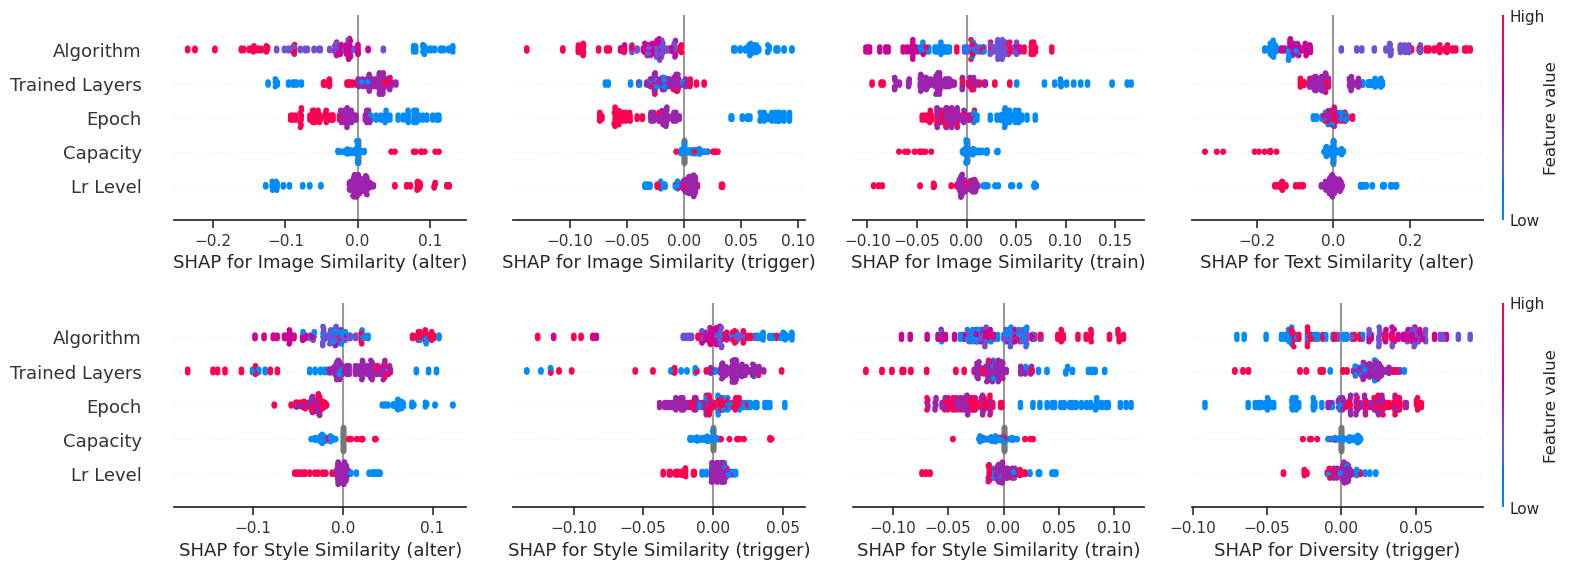

In [33]:
fig, axs = plt.subplots(2, 4, figsize=(40, 16), gridspec_kw={'width_ratios': [1, 1, 1, 1.25]})

shap_values_list = []

for i, metric in enumerate(metrics_to_include):
    plt.subplot(2, 4, i + 1)
    color_bar = (i==3) or (i==7)
    if i != 0 and i != 4:
        feature_names = ['']*5
    else:
        feature_names = ['Algorithm', 'Trained Layers', 'Epoch', 'Capacity', 'Lr Level']
    shap_values = analysis.models[metric]['shap_values']
    shap.summary_plot(shap_values,
                      analysis.X_for_plot,
                      feature_names=feature_names,
                      color_bar=color_bar,
                      show=False,
                      plot_size=(16, 6),
                      sort=False)
    plt.xlabel(f'SHAP for {metric_names[i]}')
    shap_values_list.append(shap_values)

    
plt.tight_layout()
save_dir = f"figures/appendix/"
os.makedirs(save_dir, exist_ok=True)
plt.savefig(os.path.join(save_dir, f"{category}_shap-style_loss.png"))
plt.savefig(os.path.join(save_dir, f"{category}_shap-style_loss.pdf"))

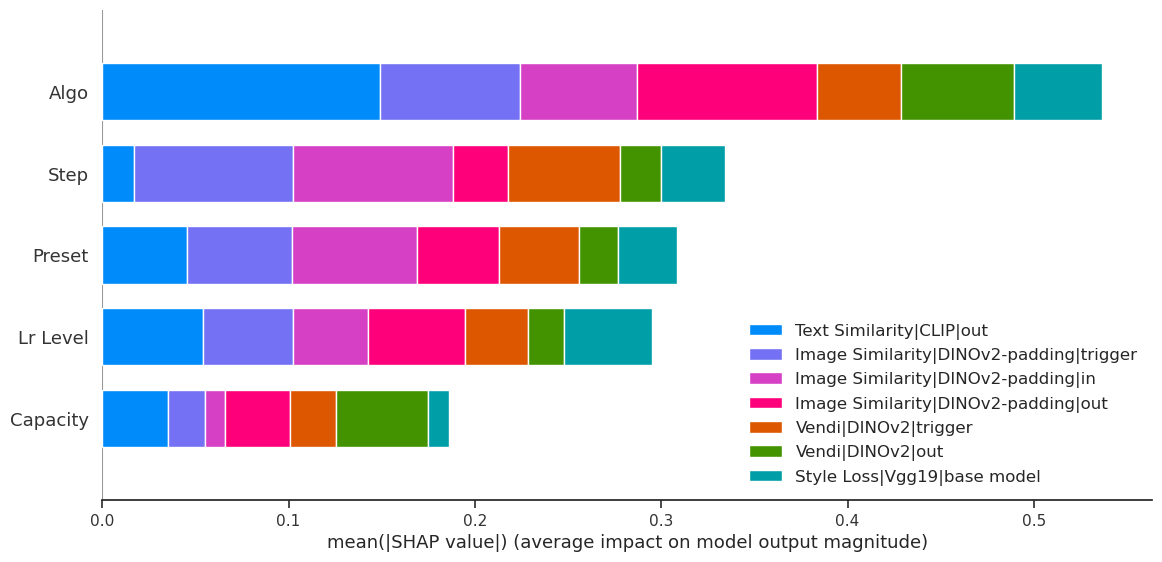

In [73]:
plt.figure(figsize=(20, 12))

shap.summary_plot(
    shap_values_list,
    analysis.X_for_plot,
    plot_type="bar",
    class_names=['|'.join(parts) for parts in metrics_to_include],
    feature_names=analysis.X_for_plot.columns,
    plot_size=(12, 6),
    show=False)
plt.savefig(
    f"figures/{category}_{metric}_shap_feature_importance.png"
)

## Per category: Scene

In [26]:
category = 'scene'

metrics_aggregated = aggregate_metrics(
    metrics_processed[metrics_processed['Category'] == category],
    level='All',
    group_seeds=False)
print(metrics_aggregated.shape)

(207, 143)


In [27]:
metrics_aggregated_10 = metrics_aggregated[metrics_aggregated['Step'] ==
                                           10].drop(columns=['Step'], level=0)

In [28]:
metrics_to_include = [('Image Similarity', 'DINOv2-padding', 'out'),
                      ('Image Similarity', 'DINOv2-padding', 'trigger'),
                      ('Image Similarity', 'DINOv2-padding', 'in'),
                      ('Text Similarity', 'CLIP', 'out'),
                      ('Vendi', 'DINOv2', 'trigger'),
                      ('Style Loss', 'Vgg19', 'base model')]

In [29]:
metric_names = [
    'Image Similarity (alter)',
    'Image Similarity (trigger)',
    'Image Similarity (train)',
    'Text Similarity (alter)',
    'Diversity (trigger)',
    'Model Preservation (style)'
]

In [30]:
analysis = FeatureAnalysis(metrics_aggregated_10,
                           keyword=category,
                           drop_step=True)
analysis.fit(metrics_to_include, test_size=None)
analysis.transform_nt()

Fitting ('Image Similarity', 'DINOv2-padding', 'out')
Training performance
RMSE: 0.08
R2: 0.91
Fitting ('Image Similarity', 'DINOv2-padding', 'trigger')
Training performance
RMSE: 0.10
R2: 0.83
Fitting ('Image Similarity', 'DINOv2-padding', 'in')
Training performance
RMSE: 0.08
R2: 0.79
Fitting ('Text Similarity', 'CLIP', 'out')
Training performance
RMSE: 0.08
R2: 0.84
Fitting ('Vendi', 'DINOv2', 'trigger')
Training performance
RMSE: 0.08
R2: 0.90
Fitting ('Style Loss', 'Vgg19', 'base model')
Training performance
RMSE: 0.14
R2: 0.31


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


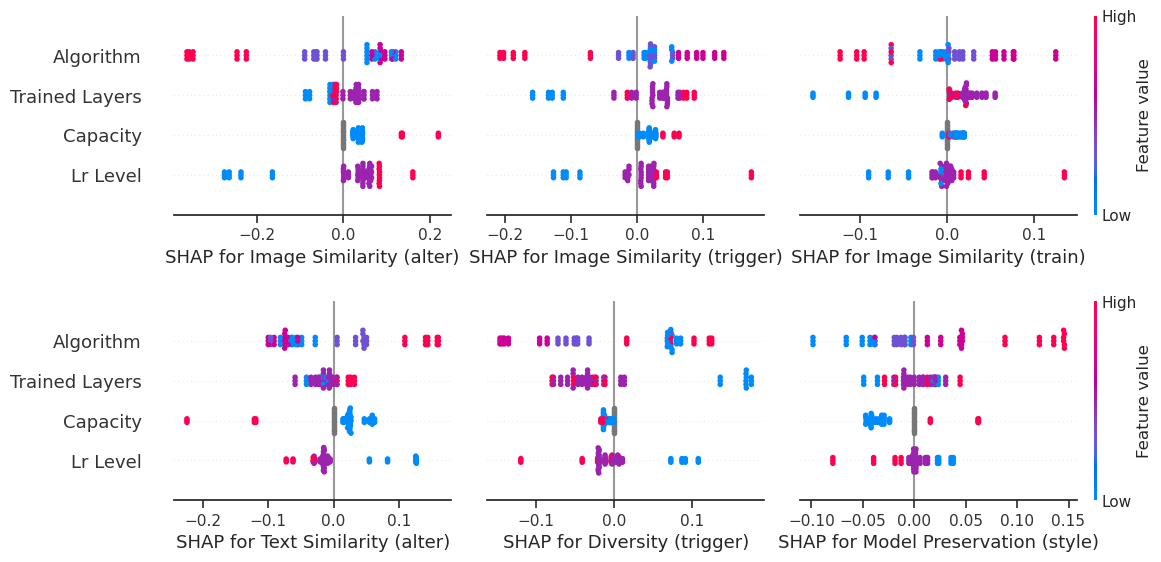

In [16]:
fig, axs = plt.subplots(2, 3, figsize=(24, 12), gridspec_kw={'width_ratios': [1, 1, 1.25]})

shap_values_list = []

for i, metric in enumerate(metrics_to_include):
    plt.subplot(2, 3, i + 1)
    color_bar = (i==2) or (i==5)
    if i != 0 and i != 3:
        feature_names = ['']*5
    else:
        feature_names = ['Algorithm', 'Trained Layers', 'Capacity', 'Lr Level']
    shap_values = analysis.models[metric]['shap_values']
    shap.summary_plot(shap_values,
                      analysis.X_for_plot,
                      feature_names=feature_names,
                      color_bar=color_bar,
                      show=False,
                      plot_size=(12, 6),
                      sort=False)
    plt.xlabel(f'SHAP for {metric_names[i]}')
    shap_values_list.append(shap_values)

plt.tight_layout()
save_dir = f"figures/appendix/"
os.makedirs(save_dir, exist_ok=True)
plt.savefig(os.path.join(save_dir, f"{category}_shap.png"))
plt.savefig(os.path.join(save_dir, f"{category}_shap.pdf"))